# Dataset Visualizer

This notebook visualizes a pre-generated dataset of expert demonstrations collected with demos.py

### Setup

- Set the root folder environment variable with `export CLIPORT_ROOT=<cliport_root>`
- Run `python cliport/demos.py n=10 mode=train task=stack-block-pyramid-seq-seen-colors` to generate a dataset for `train`, `val`, or `test`

### Generate Data

In [20]:
import os
import hydra
import numpy as np
import random

from cliport import tasks
from cliport.dataset import RavensDataset
from cliport.environments.environment import Environment
from cliport.utils import utils

import os
os.environ['CLIPORT_ROOT'] = '/sfs/weka/scratch/ys5hd/cliport'

In [21]:
# Load configs
root_dir = os.environ['CLIPORT_ROOT']
config_file = 'data.yaml' 
cfg = utils.load_hydra_config(os.path.join(root_dir, f'cliport/cfg/{config_file}'))

In [22]:
ASSETS_ROOT = "/sfs/weka/scratch/ys5hd/cliport/cliport/environments/assets/"
DATA_DIR = "/sfs/weka/scratch/ys5hd/cliport/cliport/data/"

In [24]:
# cfg['n'] = 10
# cfg['task'] = 'towers-of-hanoi-seq-seen-colors' #'stack-block-pyramid-seq-seen-colors'
# cfg['mode'] = 'test'

# cfg['n'] = 100
# cfg['task'] = 'stack-block-pyramid-seq-seen-colors' #'stack-block-pyramid-seq-seen-colors'
# cfg['mode'] = 'val'

cfg['n'] = 110
cfg['task'] = 'assembling-kits-seq-unseen-colors'
cfg['mode'] = 'test'

In [25]:
env = Environment(
    ASSETS_ROOT, #cfg['assets_root'],
    disp=cfg['disp'],
    shared_memory=cfg['shared_memory'],
    hz=480,
    record_cfg=cfg['record']
)

task = tasks.names[cfg['task']]()
task.mode = cfg['mode']
record = cfg['record']['save_video']
save_data = cfg['save_data']

# Initialize scripted oracle agent and dataset.
agent = task.oracle(env)
data_path = os.path.join(DATA_DIR, "{}-{}".format(cfg['task'], task.mode))
dataset = RavensDataset(data_path, cfg, n_demos=0, augment=False)
print(f"Saving to: {data_path}")
print(f"Mode: {task.mode}")

seed = dataset.max_seed
if seed < 0:
    if task.mode == 'train':
        seed = -2
    elif task.mode == 'val': # NOTE: beware of increasing val set to >100
        seed = -1
    elif task.mode == 'test':
        seed = -1 + 10000
    else:
        raise Exception("Invalid mode. Valid options: train, val, test")

Saving to: /sfs/weka/scratch/ys5hd/cliport/cliport/data/assembling-kits-seq-unseen-colors-test
Mode: test


In [26]:
# Collect training data from oracle demonstrations.
while dataset.n_episodes < cfg['n']:
    episode, total_reward = [], 0
    seed += 2

    # Set seeds.
    np.random.seed(seed)
    random.seed(seed)

    print('Oracle demo: {}/{} | Seed: {}'.format(dataset.n_episodes + 1, cfg['n'], seed))

    env.set_task(task)
    obs = env.reset()
    info = env.info
    reward = 0

    # Unlikely, but a safety check to prevent leaks.
    if task.mode == 'val' and seed > (-1 + 10000):
        raise Exception("!!! Seeds for val set will overlap with the test set !!!")

    # Start video recording (NOTE: super slow)
    if record:
        env.start_rec(f'{dataset.n_episodes+1:06d}')

    # Rollout expert policy
    for _ in range(task.max_steps):
        act = agent.act(obs, info)
        episode.append((obs, act, reward, info))
        lang_goal = info['lang_goal']
        obs, reward, done, info = env.step(act)
        total_reward += reward
        print(f'Total Reward: {total_reward:.3f} | Done: {done} | Goal: {lang_goal}')
        if done:
            break
                
    episode.append((obs, None, reward, info))

    # End video recording
    if record:
        env.end_rec()

    # Only save completed demonstrations.
    if save_data and total_reward > 0.99:
        dataset.add(seed, episode)

Oracle demo: 101/110 | Seed: 10211
Total Reward: 0.200 | Done: False | Goal: put the purple hexagon in the middle hexagon hole
Total Reward: 0.400 | Done: False | Goal: put the green letter M shape in the letter M shape hole
Total Reward: 0.600 | Done: False | Goal: put the red hexagon in the left hexagon hole
Total Reward: 0.800 | Done: False | Goal: put the blue hexagon in the right hexagon hole
Total Reward: 1.000 | Done: True | Goal: put the pink letter E shape in the letter E shape hole
Oracle demo: 102/110 | Seed: 10213
Total Reward: 0.200 | Done: False | Goal: put the purple letter E shape in the right letter E shape hole
Total Reward: 0.400 | Done: False | Goal: put the white heart in the bottom heart hole
Total Reward: 0.600 | Done: False | Goal: put the blue ring in the ring hole
Total Reward: 0.800 | Done: False | Goal: put the red letter E shape in the left letter E shape hole
Total Reward: 1.000 | Done: True | Goal: put the pink heart in the top heart hole
Oracle demo: 103

### Notebook

In [4]:
import os
import sys
import numpy as np
import hydra

from cliport.dataset import RavensDataset
from cliport.utils import utils
from cliport import tasks
from cliport.environments.environment import Environment

import torch

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Settings

In [5]:
### task settings
mode = 'test'
augment = True

### Uncomment the task you want to generate ###
# task = 'align-rope'
# task = 'assembling-kits-seq-seen-colors'
# task = 'assembling-kits-seq-unseen-colors'
# task = 'assembling-kits-seq-full'
# task = 'packing-shapes'
# task = 'packing-boxes-pairs-seen-colors'
# task = 'packing-boxes-pairs-unseen-colors'
# task = 'packing-boxes-pairs-full'
# task = 'packing-seen-google-objects-seq'
# task = 'packing-unseen-google-objects-seq'
# task = 'packing-seen-google-objects-group'
# task = 'packing-unseen-google-objects-group'
# task = 'put-block-in-bowl-seen-colors'
# task = 'put-block-in-bowl-unseen-colors'
# task = 'put-block-in-bowl-full'
task = 'stack-block-pyramid-seq-seen-colors'
# task = 'stack-block-pyramid-seq-unseen-colors'
# task = 'stack-block-pyramid-seq-full'
# task = 'separating-piles-seen-colors'
# task = 'separating-piles-unseen-colors'
# task = 'separating-piles-full'
# task = 'towers-of-hanoi-seq-seen-colors'
# task = 'towers-of-hanoi-seq-unseen-colors'
# task = 'towers-of-hanoi-seq-full'

### visualization settings
max_episodes = 1
max_steps = 100

### Load configs

In [6]:
os.environ['CLIPORT_ROOT'] = '/sfs/weka/scratch/ys5hd/cliport'

In [7]:
# Load configs
root_dir = os.environ['CLIPORT_ROOT']
config_file = 'train.yaml' 
cfg = utils.load_hydra_config(os.path.join(root_dir, f'cliport/cfg/{config_file}'))

# Override defaults
cfg['task'] = task
cfg['mode'] = mode

data_dir = os.path.join(root_dir, 'cliport/data')

### Load dataset

In [8]:
task = tasks.names[cfg['task']]()
task.mode = mode

ds = RavensDataset(os.path.join(data_dir, f'{cfg["task"]}-{cfg["mode"]}'), cfg, augment=augment)

### Iterate through dataset



Episode: 1/10

Step: 1/8


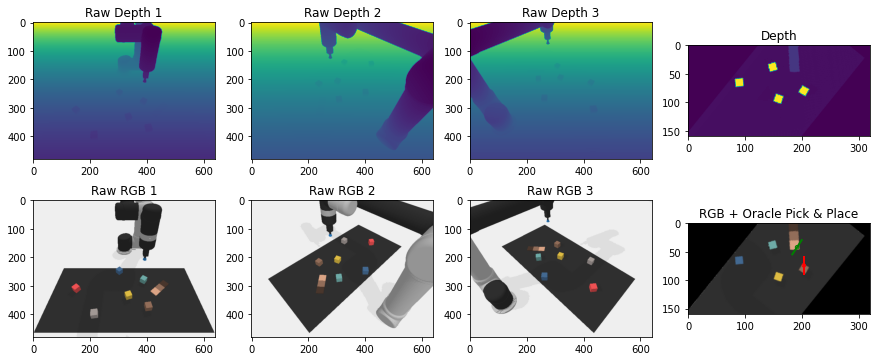

Language Goal: put the brown block on the lightest brown block
Step Reward: 0
Total Reward: 0

Step: 2/8


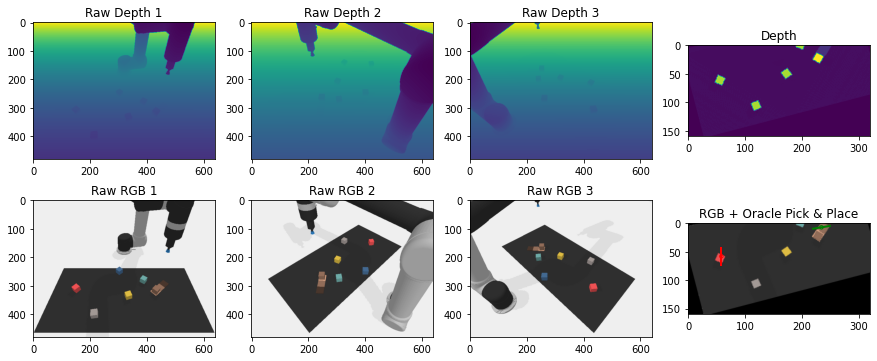

Language Goal: put the red block on the middle brown block
Step Reward: 0.16666666666666666
Total Reward: 0.16666666666666666

Step: 3/8


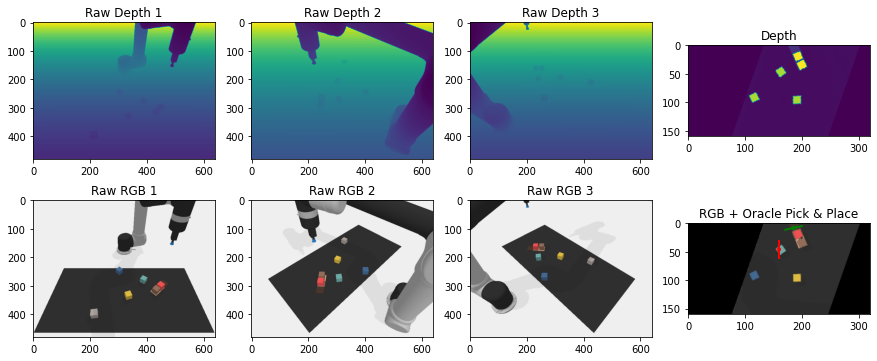

Language Goal: put the cyan block on the darkest brown block
Step Reward: 0.16666666666666666
Total Reward: 0.3333333333333333

Step: 4/8


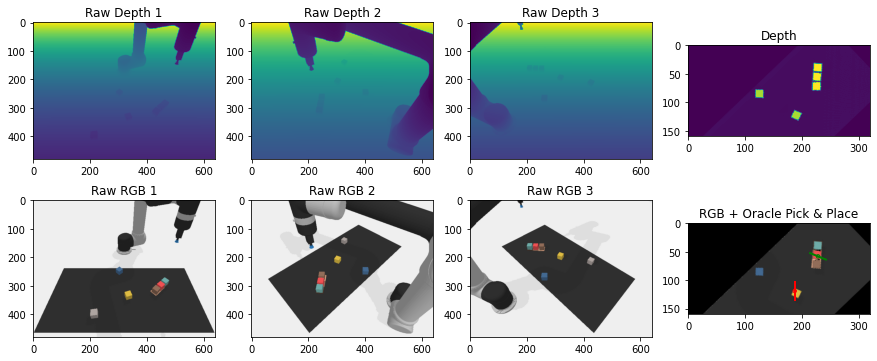

Language Goal: put the yellow block on the brown and red blocks
Step Reward: 0.16666666666666669
Total Reward: 0.5

Step: 5/8


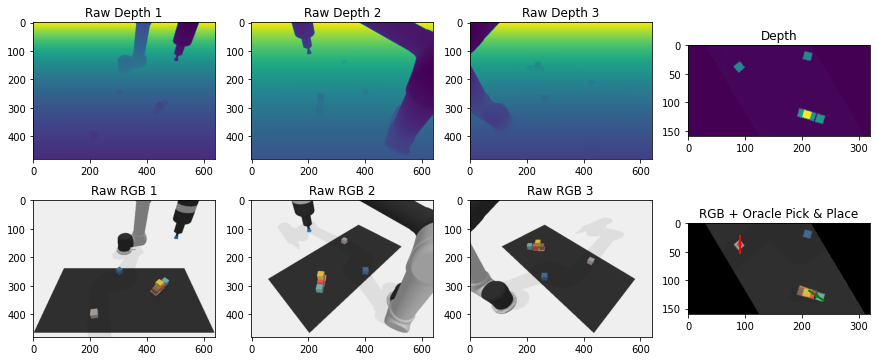

Language Goal: put the gray block on the red and cyan blocks
Step Reward: 0.16666666666666663
Total Reward: 0.6666666666666666

Step: 6/8


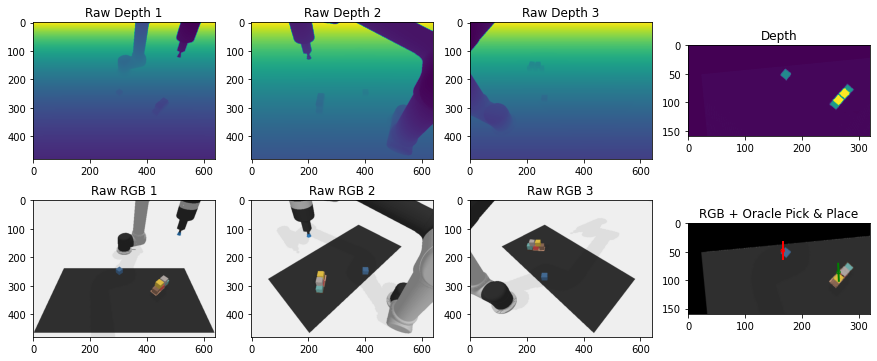

Language Goal: put the blue block on the yellow and gray blocks
Step Reward: 0.16666666666666663
Total Reward: 0.8333333333333333

Step: 7/8


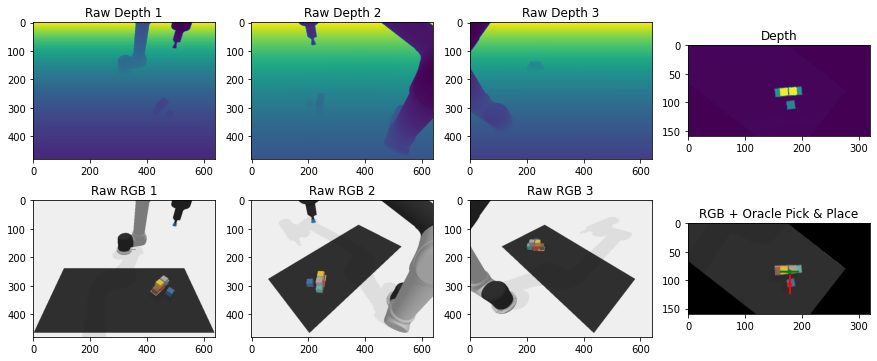

Language Goal: put the blue block on the yellow and gray blocks
Step Reward: 0.0
Total Reward: 0.8333333333333333

Step: 8/8


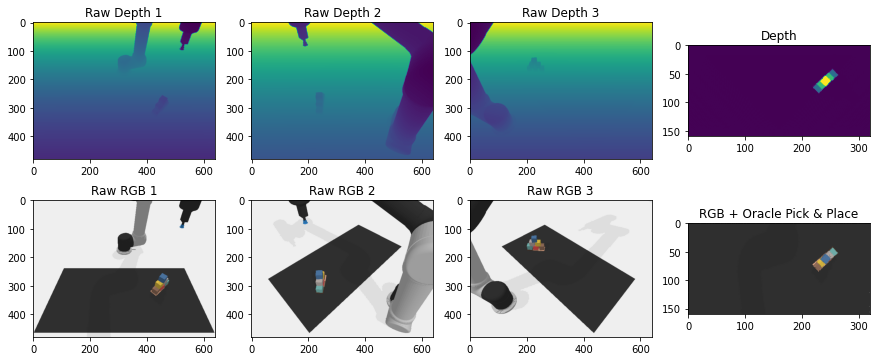

Language Goal: done stacking block pyramid.
Step Reward: 0.16666666666666663
Total Reward: 0.9999999999999999
Done, Total Reward: 0.9999999999999999


Dataset Statistics: 
Color Mean: [0.60516891 0.60434091 0.60349076], Std: [0.00866056 0.00919188 0.00936011]
Depth Mean: 1.1276633739471436, Std: 0.015365613624453545
Total Image-Action Pairs: 7


In [9]:
color_sums = []
depth_sums = []

total_images = 0

for i in range(0, min(max_episodes, ds.n_episodes)):
    print(f'\n\nEpisode: {i + 1}/{ds.n_episodes}')
    episode, seed = ds.load(i)
    
    total_images += len(episode)-1
    
    total_reward = 0
    for step in range(min(max_steps, len(episode))):
        print(f"\nStep: {step+1}/{len(episode)}")
        obs, act, reward, info = episode[step]
        
        total_reward += reward
        batch = ds[i]
        
        num_images = len(obs['color'])
        fig, axs = plt.subplots(2, num_images+1, figsize=(15, 6))
        for n in range(num_images):
            axs[1, n].imshow(obs['color'][n])
            axs[1, n].set_title(f'Raw RGB {n+1}')
            
            axs[0, n].imshow(obs['depth'][n])
            axs[0, n].set_title(f'Raw Depth {n+1}')
            
        color_sums.append(np.mean(obs['color'][0], axis=(0,1)) / 255.0)
        depth_sums.append(np.mean(obs['depth'][0], axis=(0,1)))
        
        cam_config = None
        if b'camera_info' in info:
            cam_config = ds.get_cam_config(info[b'camera_info'])
        
        img_depth = ds.get_image(obs, cam_config=cam_config)
        img_tensor = torch.from_numpy(img_depth)
        img = np.uint8(img_tensor.detach().cpu().numpy())
        img = img.transpose(1,0,2)
        
        if step < len(episode)-1 and episode[step]:
            batch = ds.process_sample(episode[step], augment=augment)
        else:
            batch = ds.process_goal(episode[step], perturb_params=None)
        
        img_sample = batch['img']
        img_sample = torch.from_numpy(img_sample)
        color = np.uint8(img_sample.detach().cpu().numpy())[:,:,:3]
        color = color.transpose(1,0,2)
        depth = np.array(img_sample.detach().cpu().numpy())[:,:,3]
        depth = depth.transpose(1,0)
        
        axs[0, num_images].imshow(depth)
        axs[0, num_images].set_title('Depth')
        
        axs[1,num_images].imshow(color)
        axs[1,num_images].set_title('RGB + Oracle Pick & Place')
        
        if act and step < len(episode)-1:
            p0 = batch['p0']
            p1 = batch['p1']
            p0_theta = batch['p0_theta']
            p1_theta = batch['p1_theta'] + p0_theta
            
            pick = p0
            place = p1
                
            line_len = 30
            pick0 = (pick[0] + line_len/2.0 * np.sin(p0_theta), pick[1] + line_len/2.0 * np.cos(p0_theta))
            pick1  = (pick[0] - line_len/2.0 * np.sin(p0_theta), pick[1] - line_len/2.0 * np.cos(p0_theta))
            axs[1,num_images].plot((pick1[0], pick0[0]), (pick1[1], pick0[1]), color='r', linewidth=2)
            
            place0 = (place[0] + line_len/2.0 * np.sin(p1_theta), place[1] + line_len/2.0 * np.cos(p1_theta))
            place1  = (place[0] - line_len/2.0 * np.sin(p1_theta), place[1] - line_len/2.0 * np.cos(p1_theta))
            axs[1,num_images].plot((place1[0], place0[0]), (place1[1], place0[1]), color='g', linewidth=2)
            
            c_pick = plt.Circle(pick, 3, color='r', fill=False)
            c_place = plt.Circle(place, 3, color='g', fill=False)

            axs[1,num_images].add_patch(c_pick)
            axs[1,num_images].add_patch(c_place)
            
        plt.show()
        
        print(f"Language Goal: {batch['lang_goal']}")
        print(f"Step Reward: {reward}")
        print(f"Total Reward: {total_reward}")

    print(f"Done, Total Reward: {total_reward}")

print("\n\nDataset Statistics: ")
print(f"Color Mean: {np.mean(color_sums, axis=0)}, Std: {np.std(color_sums, axis=0)}")
print(f"Depth Mean: {np.mean(depth_sums, axis=0)}, Std: {np.std(depth_sums, axis=0)}")
print(f"Total Image-Action Pairs: {total_images}")